## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

#%matplotlib qt
%matplotlib inline

In [ ]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

def get_camera_calibration_parameters(globdir='./camera_cal/calibration*.jpg'):
     

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(globdir)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    assert len(objpoints) == len(imgpoints) # Check if same number of object and image point found

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist

def get_warp_parameters():
    ## TODO: Other solution for img.shape!
    img = mpimg.imread('./test_images/straight_lines2.jpg')
    src = np.float32(
        [(img.shape[1]/2-60, 450),
         (img.shape[1]/2+60, 450),
         (img.shape[1]-150, img.shape[0]-40),
         (150, img.shape[0]-40)])

    dst = np.float32(
        [(450, 200),
         (img.shape[1]-450, 200),
         (img.shape[1]-450, img.shape[0]),
         (450, img.shape[0])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

ret, mtx, dist = get_camera_calibration_parameters()
M, Minv = get_warp_parameters()

In [320]:
def print_example_images(img, img_aug):
    plt.figure(figsize=(17,5))
    plt.subplot(121), plt.xticks([]), plt.yticks([])
    plt.imshow(img)
    plt.subplot(122), plt.xticks([]), plt.yticks([])
    if img_aug.ndim == 3:
        plt.imshow(img_aug)
    else:
        plt.imshow(img_aug, cmap='gray')
    plt.show()

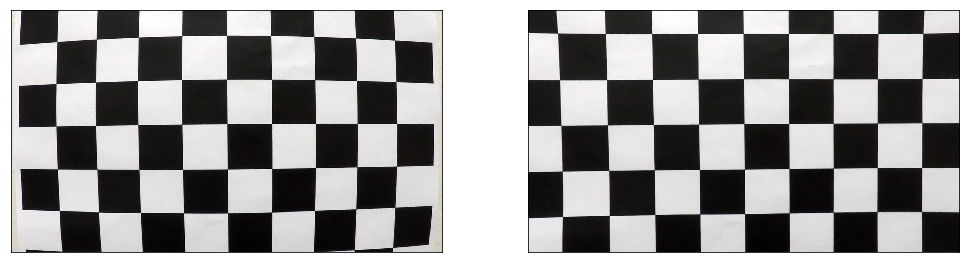

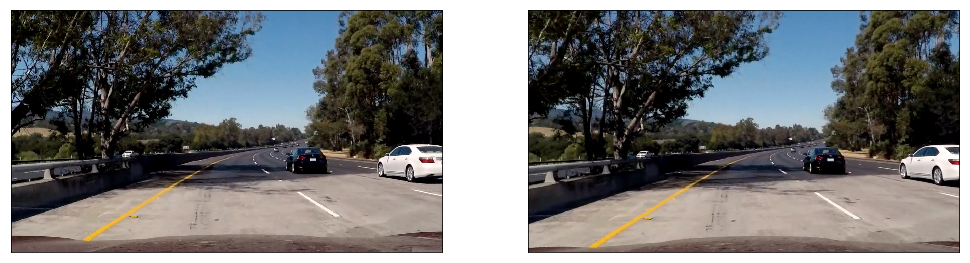

In [321]:
#1. pipeline step: Undistort image

def undistort_img(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


## undistortion demo
img = mpimg.imread('./camera_cal/calibration1.jpg')
dst = undistort_img(img, mtx, dist)
print_example_images(img, dst)

img = mpimg.imread('./test_images/test5.jpg')
dst = undistort_img(img, mtx, dist)
print_example_images(img, dst)

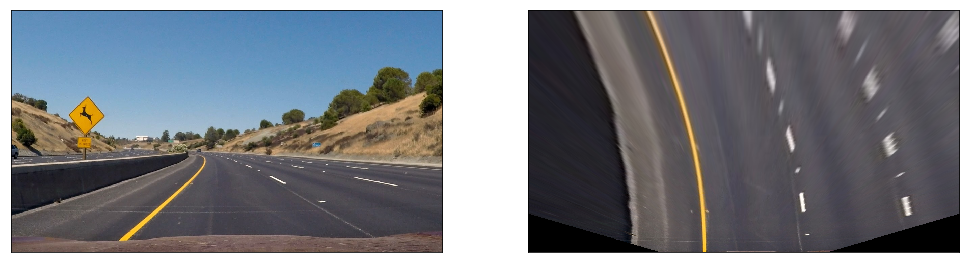

In [322]:
def birdview_warp(img, M=M):
    return cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)


## Image warping demo
img = mpimg.imread('./test_images/test2.jpg')
warped = birdview_warp(img)
print_example_images(img, warped)

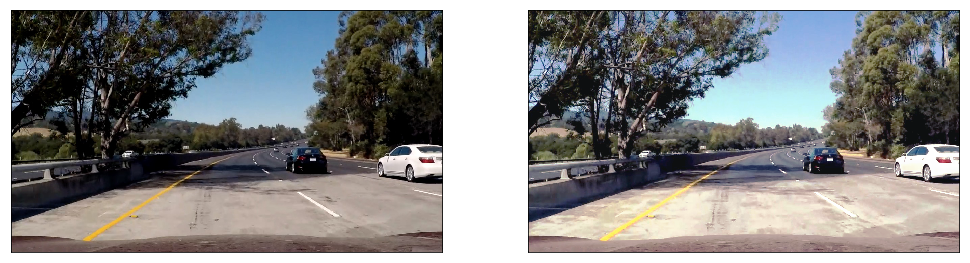

103.887117332
70.0748770255


In [323]:
def histogram_equ(img):
    from skimage import exposure
    img_hist = img.copy()
    
    #p2, p98 = np.percentile(img[:,:,0], (5, 95))
    #img_hist[:,:,0:] = exposure.rescale_intensity(img[:,:,0:], in_range=(p2, p98))
    #img_hist = np.clip(img_hist, 0, 255)
    
    for n in range(img.shape[2]):
        #img_hist[:,:,n] = cv2.equalizeHist(img[:,:,n])
        img_hist[:,:,n] = exposure.equalize_hist(img[:,:,n])*255
        #img_hist[:,:,n] = exposure.equalize_adapthist(img[:,:,n], clip_limit=0.03, nbins=256)*256
        #img_hist[:,:,n] = exposure.adjust_log(img[:,:,n], gain=1.5, inv=True)#*255
       #img_hist[:,:,n] = exposure.adjust_gamma(img[:,:,n], gamma=0.5)#*255
    return img_hist


## Demo
img = mpimg.imread('./test_images/test5.jpg')
hist = histogram_equ(img)
print_example_images(img, hist)
print(np.mean(img[360:,:,:]))
print(np.mean(warped[360:,:,:]))

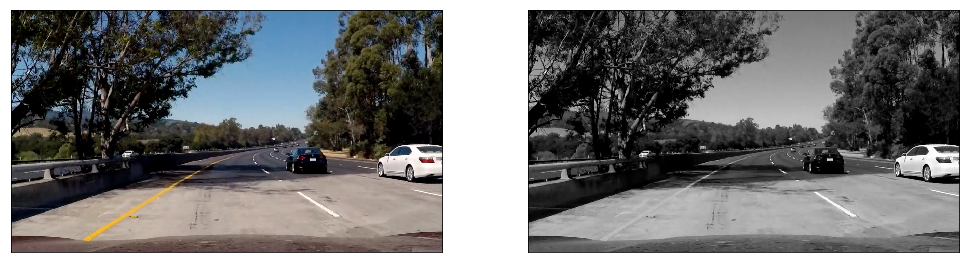

In [324]:
def get_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray


#demo
img = mpimg.imread('./test_images/test5.jpg')
gray = get_grayscale(img)
print_example_images(img, gray)

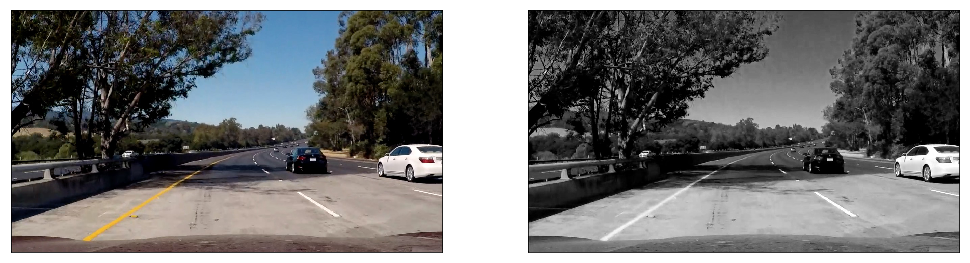

In [325]:
def get_redchannel(img):
    red = img[:,:,0].copy() ## use red channel
    return red


#demo
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
print_example_images(img, red)

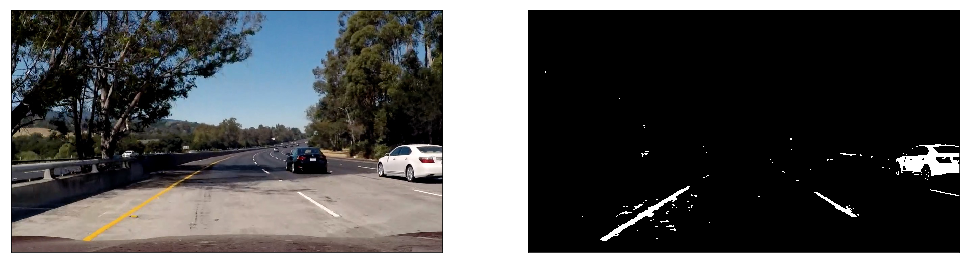

In [246]:
def apply_threshold(img, thresh=(0,255)):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output


##demo
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
thresh = apply_threshold(red, thresh=(200, 255))
print_example_images(img, thresh)

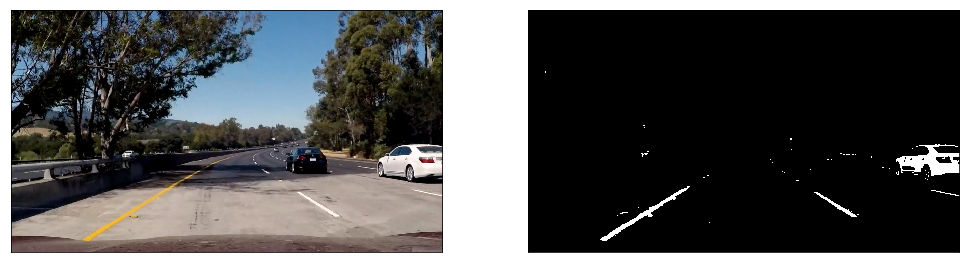

In [282]:
def apply_threshold_dynamic(img, percentile=0.03):
    binary_output = np.zeros_like(img)
    lower_thresh = 255
    while np.mean(binary_output[360:,:]) < (percentile):
        lower_thresh -= 5
        binary_output[(img >= lower_thresh)] = 1
    return binary_output


##demo
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic(red, percentile=0.03)
print_example_images(img, thresh)

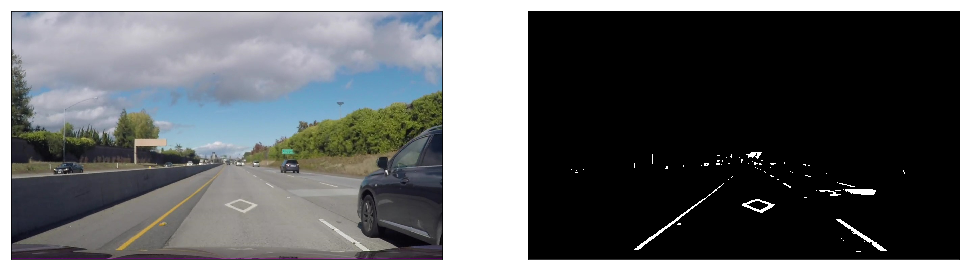

In [359]:
def apply_threshold_dynamic2(img, percentile=0.03):
    binary_output = np.zeros_like(img)
    percentile = 100 - (percentile*100)
    lower_thresh = np.percentile(img[360:,:], percentile)
    binary_output[(img >= lower_thresh)] = 1
    binary_output[:420,:] = 0
    return binary_output
 

##demo
img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h33m05s984.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
print_example_images(img, thresh)

In [360]:
def sobel_parameters(img, 
                     thresh_abs_x = (0.01, 1), 
                     thresh_abs_y = (0.01, 1), 
                     thresh_mag = (0.05, 1), 
                     thresh_dir = (0, 1)):
    
    # vertical contrast borders. Note that a Scharr kernel is used here for better performance 
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=-1)
    
    # horizontal contrast borders. Scharr kernel
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=-1)
    
    # diagonal contrast borders high->low. Scharr kernel
    kernel10 = np.array([[0, -3, -10],[3, 0, -3],[10, 3, 0]]) 
    sobel10 = cv2.filter2D(img, -1, kernel10)
    
    # diagonal contrast borders low->high. Scharr kernel
    kernel01 = np.array([[10, 3, 0],[3, 0, -3],[0, -3, -10]]) 
    sobel01 = cv2.filter2D(img, -1, kernel01)
     
    # calculate value (sharpness) of contrast border and apply threshold to it
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # threshold values 
    scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
    binary_output_x = np.zeros_like(scaled_sobelx)
    binary_output_x[(scaled_sobelx >= thresh_abs_x[0]) & (scaled_sobelx <= thresh_abs_x[1])] = 1
    
    scaled_sobely = abs_sobely/np.max(abs_sobely)
    binary_output_y = np.zeros_like(scaled_sobely)
    binary_output_y[(scaled_sobely >= thresh_abs_y[0]) & (scaled_sobely <= thresh_abs_y[1])] = 1
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag = mag/np.max(mag)
    binary_output_mag = np.zeros_like(scaled_mag)
    binary_output_mag[(scaled_mag >= thresh_mag[0]) & (scaled_mag <= thresh_mag[1])] = 1
    
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_output_dir = np.zeros_like(dir_grad)
    binary_output_dir[(dir_grad > thresh_dir[0]) & (dir_grad <= thresh_dir[1])] = 1
    
    # put all binary images into one big numpy array
    bin_out = img.copy()
    bin_out = np.dstack((bin_out, binary_output_x))
    bin_out = np.dstack((bin_out, binary_output_y))
    bin_out = np.dstack((bin_out, binary_output_mag))
    bin_out = np.dstack((bin_out, binary_output_dir))
    
    dir_mag = np.zeros_like(binary_output_dir)
    dir_mag[(bin_out[:,:,3] == 1) & (bin_out[:,:,4] == 1)] = 1
    bin_out = np.dstack((bin_out, dir_mag))
    
    combined = np.zeros_like(binary_output_dir)
    combined[(bin_out[:,:,1] == 1) & (bin_out[:,:,2] == 1) & (bin_out[:,:,3] == 1) & (bin_out[:,:,4] == 1)] = 1
    bin_out = np.dstack((bin_out, combined))
    
    
    return bin_out

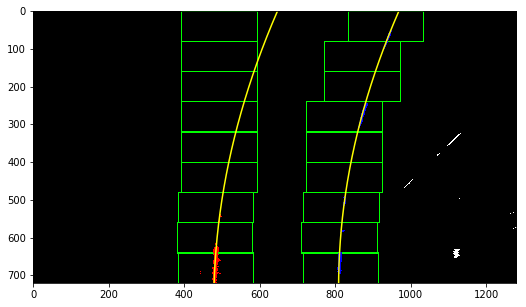

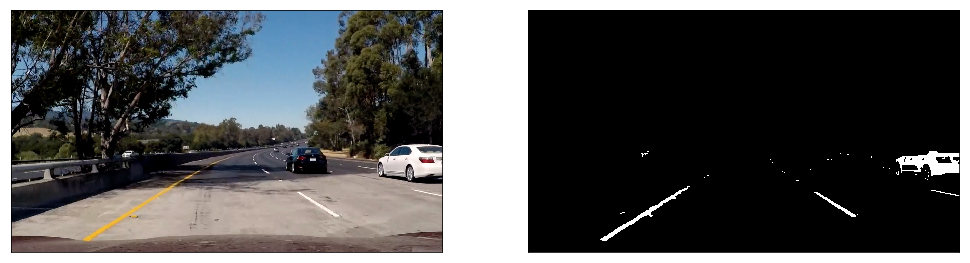

[477 478 479 ..., 492 493 494]
[640 640 640 ..., 559 559 559]


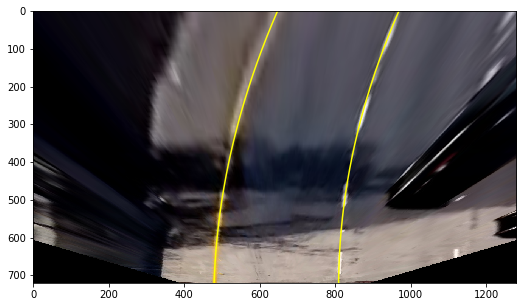

In [378]:
def findlines(img):
    
    histogram = np.sum(img[int(img.shape[0]/2):,400:880], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base + 400
    rightx_current = rightx_base + 400
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure(figsize=(17,5))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    return left_fit, right_fit, leftx, lefty, rightx, righty


class Line():
    def __init__():
        self.left_fit_group = []
        self.right_fit_group = []

        
## Demo
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
birdview = birdview_warp(thresh)
left_fit, right_fit, leftx, lefty, rightx, righty = findlines(birdview)
print_example_images(img, thresh)

print(leftx)
print(lefty)

# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


plt.figure(figsize=(17,5))
plt.imshow(birdview_warp(img), cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


window_lower_border:  720 upper border:  640
window_lower_border:  640 upper border:  560
window_lower_border:  560 upper border:  480
window_lower_border:  480 upper border:  400
window_lower_border:  400 upper border:  320
window_lower_border:  320 upper border:  240
window_lower_border:  240 upper border:  160
window_lower_border:  160 upper border:  80
window_lower_border:  80 upper border:  0


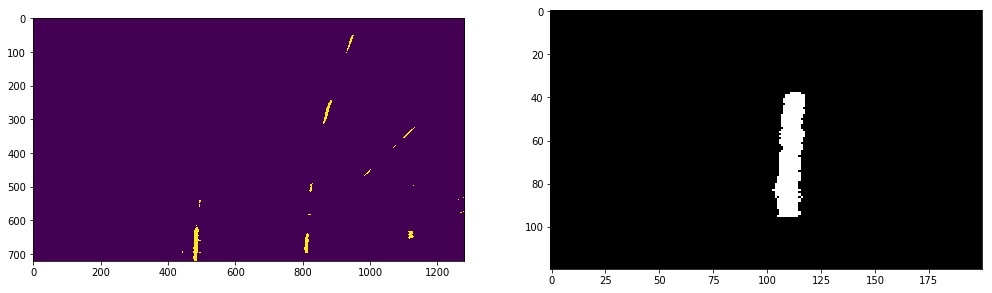

[ 46  46  46  46  46  47  47  47  47  47  47  47  47  47  48  48  48  48
  48  48  48  48  48  49  49  49  49  49  49  49  49  49  49  50  50  50
  50  50  50  50  50  50  50  51  51  51  51  51  51  51  51  51  52  52
  52  52  52  52  52  52  52  52  53  53  53  53  53  53  53  53  53  54
  54  54  54  54  54  54  54  54  54  55  55  55  55  55  55  55  55  55
  55  56  56  56  56  56  56  56  56  56  56  57  57  57  57  57  57  57
  57  57  57  58  58  58  58  58  58  58  58  58  59  59  59  59  59  59
  59  59  59  59  60  60  60  60  60  60  60  60  60  60  61  61  61  61
  61  61  61  61  61  62  62  62  62  62  62  62  62  63  63  63  63  63
  63  63  63  63  63  64  64  64  64  64  64  64  64  64  64  64  64  65
  65  65  65  65  65  65  65  65  65  65  66  66  66  66  66  66  66  66
  66  66  66  66  67  67  67  67  67  67  67  67  67  67  68  68  68  68
  68  68  68  68  68  68  68  69  69  69  69  69  69  69  69  69  69  70
  70  70  70  70  70  70  70  70  70  71  71  71  7

In [410]:
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
birdview = birdview_warp(thresh)

nwindows = 9
window_height = np.int(img.shape[0]/nwindows)

left_peak = 800

for n in range(nwindows):
    window_lower_border = img.shape[0] - n*window_height
    window_slice = birdview[window_lower_border-window_height:window_lower_border, :]
    #test = birdview[window_lower_border-window_height:window_lower_border, left_peak-100:left_peak+100]
    print('window_lower_border: ', window_lower_border, 'upper border: ', window_lower_border-window_height)
    
    
    
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.imshow(birdview)
plt.subplot(122)

plt.imshow(test, cmap='gray')
plt.show()


test_nonzero = np.nonzero(test)
test_nonzeroy = np.array(test_nonzero[0])+n
test_nonzerox = np.array(test_nonzero[1])+left_peak-100
print(test_nonzeroy)
print(test_nonzerox)

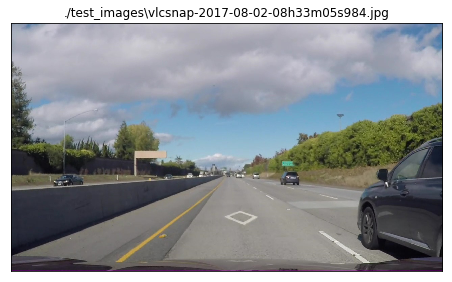

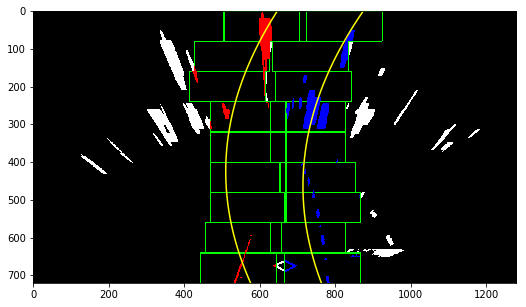

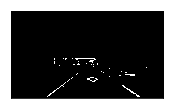

In [344]:
# define pipeline for lane detection
def pipeline_advanced_lane_finding(img):
    
    undist = undistort_img(img, mtx, dist)
    # 1. red channel with color thresholding
    red = get_redchannel(undist)
    #thresh_red = apply_threshold_dynamic(red, percentile=0.015)
    thresh_red = apply_threshold_dynamic2(red, percentile=0.03)
    
    # 2. cmyk with yellow channel and color thresholding
    # 3. TODO: HSV with S channel and color thresholding    
    #sobel = sobel_parameters(thresh_red)[:,:,6]
    
    
    combined = np.zeros_like(thresh_red)
    combined[(thresh_red == 1)] = 1 #& (bin_out[:,:,2] == 1) & (bin_out[:,:,3] == 1) & (bin_out[:,:,4] == 1)] = 1
    
    
    birdview = birdview_warp(combined)
    
    findlines(birdview)
    
    #left_smoothed, right_smoothed = Line.smooth(left_fit, right_fit)
    
    
    return thresh_red


#print all test images and how the pipeline works

images = glob.glob('./test_images/vlcsnap-2017-08-02-08h33m05s984*')


for n, filename in enumerate(images):
    img = mpimg.imread(filename)
    plt.figure(figsize=(17,5))
    plt.subplot(1, 2, 1), plt.xticks([]), plt.yticks([])
    plt.title(filename)
    plt.imshow(img)
    dst = pipeline_advanced_lane_finding(img)
    plt.subplot(1, 2, 2), plt.xticks([]), plt.yticks([])
    plt.imshow(dst, cmap='gray')



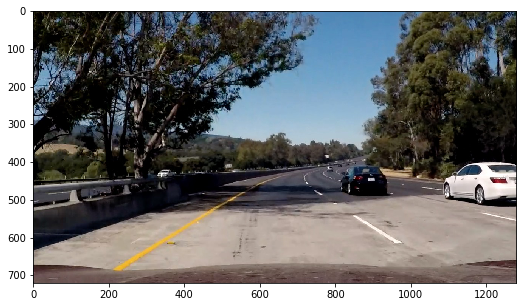

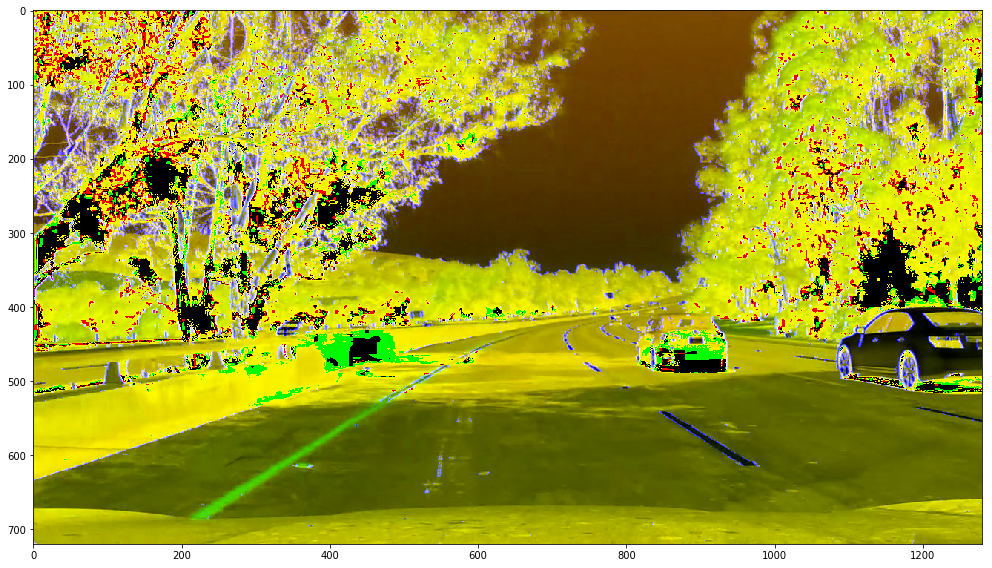

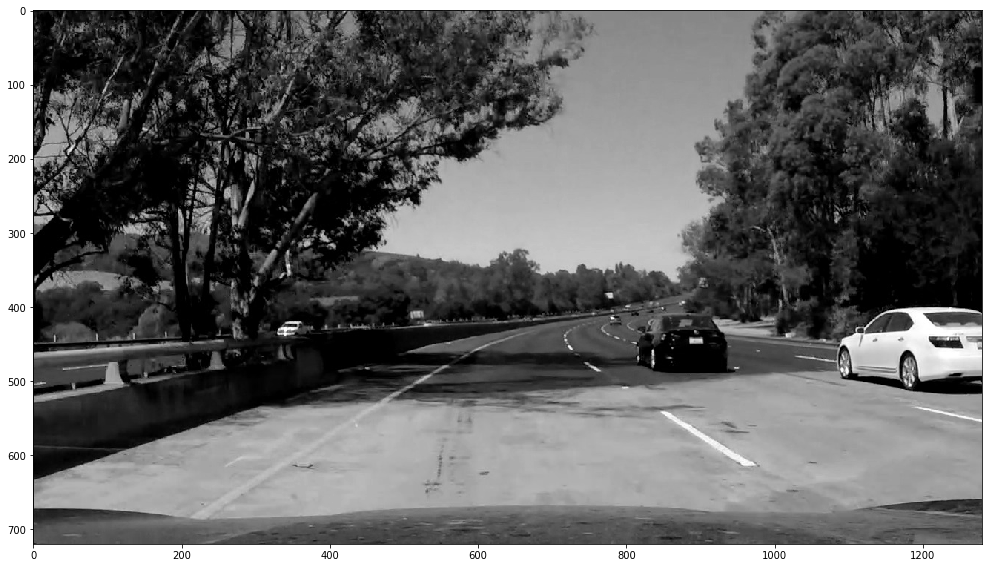

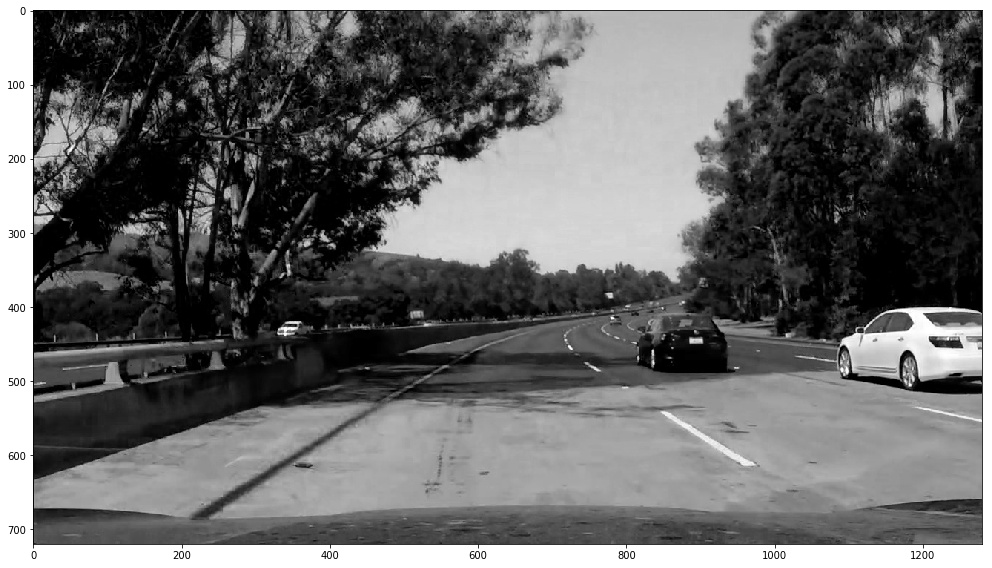

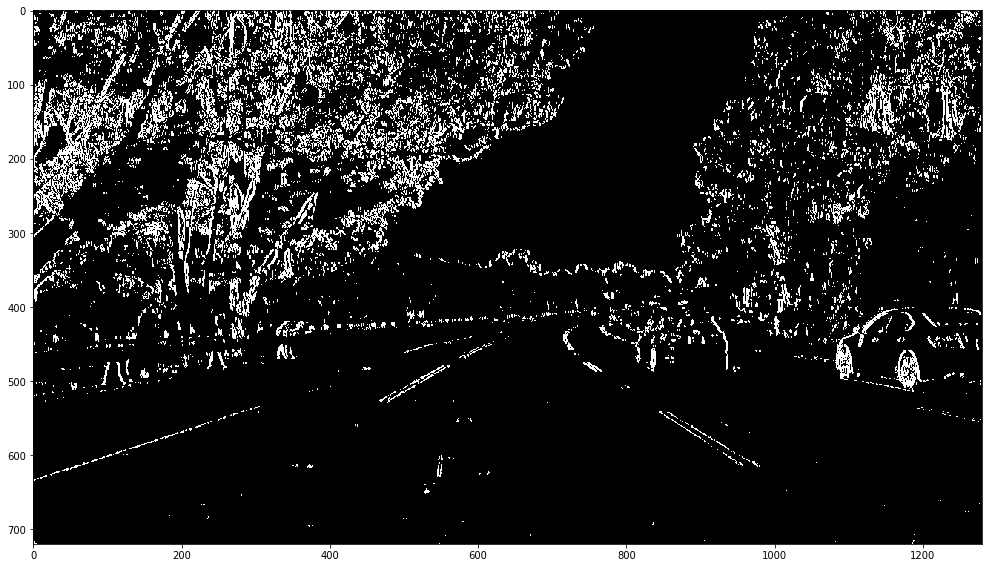

In [22]:
img = mpimg.imread('./test_images/test5.jpg')
plt.figure(figsize=(17,5))
plt.imshow(img)

bin_out = sobel_parameters(img)
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,1:4], cmap='gray')


plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,1], cmap='gray')
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,2], cmap='gray')
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,3], cmap='gray')

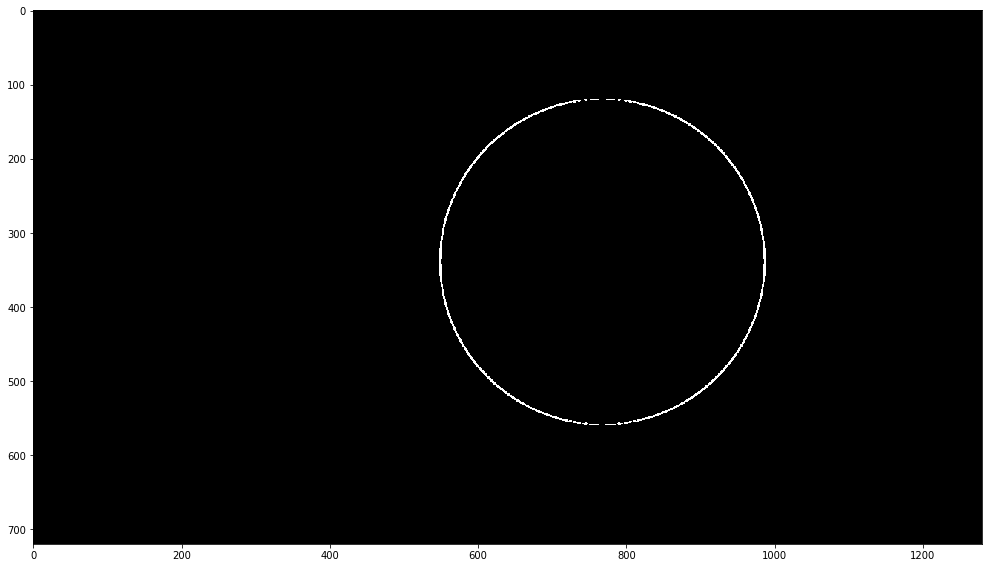

In [106]:
from IPython.html.widgets import *


def sobel(thresh_abs_x_low = 0, thresh_abs_x_high = 1,
         thresh_abs_y_low = 0, thresh_abs_y_high = 1, 
         thresh_mag_low = 0, thresh_mag_high = 1,
         thresh_dir_low = 0, thresh_dir_high=1):
    
    
    img = mpimg.imread('./test_images/circle.jpg')
    gray = grayscale(img)
    #birdview = birdview_warp(gray)
    bin_out = sobel_parameters(gray, 
                               thresh_abs_x = (thresh_abs_x_low, thresh_abs_x_high), 
                                thresh_abs_y = (thresh_abs_y_low, thresh_abs_y_high), 
                                thresh_mag = (thresh_mag_low, thresh_mag_high), 
                                thresh_dir = (thresh_dir_low, thresh_dir_high))
    
    plt.figure(figsize=(17,10))
    #out = np.dstack((bin_out[:,:,1], bin_out[:,:,2], bin_out[:,:,5]))
    plt.imshow(bin_out[:,:,6], cmap='gray')
    plt.show()
    return

interact(sobel, thresh_abs_x_low = (0,1,0.01), thresh_abs_x_high = (0,1,0.01),
         thresh_abs_y_low = (0,1,0.01), thresh_abs_y_high = (0,1,0.01), 
         thresh_mag_low = (0,1,0.01), thresh_mag_high = (0,1,0.01),
         thresh_dir_low = (0,1.57,0.01), thresh_dir_high= (0,1.57,0.01))

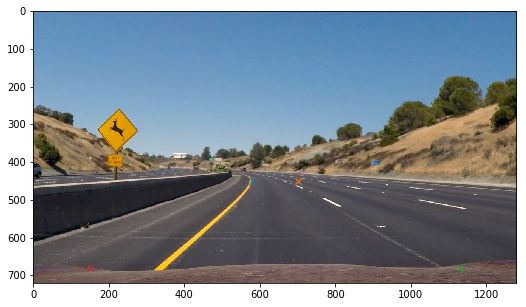

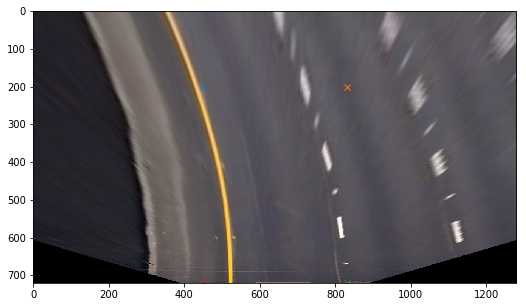

In [ ]:
## sobel demo
img = mpimg.imread('./test_images/circle.png')
plt.figure(figsize=(17,5))
plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
print(sobelx.shape, sobelx.max(), sobelx.min())
placeholder = gray.copy()

# set parameters
thresh_abs_x = (150, 255)
thresh_abs_y = (150, 255)
thresh_mag = (150, 255)
thresh_dir = (0, 0.1)

# abs
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
binary_output_x = np.zeros_like(scaled_sobelx)
binary_output_x[(scaled_sobelx > thresh_abs_x[0]) & (scaled_sobelx < thresh_abs_x[1])] = 1
placeholder = np.dstack((placeholder, binary_output_x))

abs_sobely = np.absolute(sobely)
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
binary_output_y = np.zeros_like(scaled_sobely)
binary_output_y[(scaled_sobely > thresh_abs_y[0]) & (scaled_sobely < thresh_abs_y[1])] = 1
placeholder = np.dstack((placeholder, binary_output_y))

# mag
mag = np.sqrt(sobelx**2 + sobely**2)
scaled_mag = np.uint8(255*mag/np.max(mag))
binary_output_mag = np.zeros_like(scaled_mag)
binary_output_mag[(scaled_mag > thresh_mag[0]) & (scaled_mag < thresh_mag[1])] = 1
placeholder = np.dstack((placeholder, binary_output_mag))

# direction
#thresh_dir = (thresh_dir*np.pi)-(np.pi/2)
dir_grad = np.arctan2(abs_sobely, abs_sobelx)
binary_output_dir = np.zeros_like(dir_grad)
binary_output_dir[(dir_grad > thresh_dir[0]) & (dir_grad <= thresh_dir[1])] = 1
placeholder = np.dstack((placeholder, binary_output_dir))


plt.figure(figsize=(17,5))
plt.imshow(gray, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_x, cmap='gray')


plt.figure(figsize=(17,5))
plt.imshow(binary_output_y, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_mag, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_dir, cmap='gray')

print(placeholder.shape)

In [ ]:
abs_sobelx = np.absolute(sobelx)
print(abs_sobelx.min(), abs_sobelx.max())
scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
print(scaled_sobelx.min(), scaled_sobelx.max())
binary_output_x = np.zeros_like(scaled_sobelx)
binary_output_x[(scaled_sobelx >= thresh_abs_x[0]) & (scaled_sobelx <= thresh_abs_x[1])] = 1
placeholder = np.dstack((placeholder, binary_output_x))

In [ ]:
# color space demo
from skimage import exposure

img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h34m19s558.jpg')
plt.figure(figsize=(17,5))
plt.imshow(img)
img = hist_equ(img)

plt.figure(figsize=(17,5))
plt.imshow(img)

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#img_hsv= img

plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,0], cmap='gray')
plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,1], cmap='gray')
plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,2], cmap='gray')

In [ ]:
# test with custom sobel kernel
img = mpimg.imread('./test_images/circle.png')

kernel10 = np.array([[0, -3, -10],[3, 0, -3],[10, 3, 0]]) 

kernel01 = np.array([[10, 3, 0],[3, 0, -3],[0, -3, -10]]) 

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

sobel_custom1 = cv2.filter2D(gray, -1, kernel10)
plt.figure(figsize=(17,10))
plt.imshow(sobel_custom1, cmap='gray')

sobel_custom2 = cv2.filter2D(gray, -1, kernel01)
plt.figure(figsize=(17,10))
plt.imshow(sobel_custom2, cmap='gray')

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
plt.figure(figsize=(17,10))
plt.imshow(sobelx, cmap='gray')

sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
plt.figure(figsize=(17,10))
plt.imshow(sobely, cmap='gray')

In [125]:
x = np.array(range(0,3))

for n in range(6,15):
    print(x.size)
    x = np.append(x, n)
    if x.size > 5:
        x = x[1:]
    print(x)



3
[0 1 2 6]
4
[0 1 2 6 7]
5
[1 2 6 7 8]
5
[2 6 7 8 9]
5
[ 6  7  8  9 10]
5
[ 7  8  9 10 11]
5
[ 8  9 10 11 12]
5
[ 9 10 11 12 13]
5
[10 11 12 13 14]
